# Wengert lists

## Warning: This notebook is under construction. Probably shouldn't have pushed it to GitHub, to be honest. 

In this notebook I will lay out the concept of Wengert lists, and how they are used in automatic differentiation.
Finally, I will write a code implementation I can use with the neural network I have already written.

## Motivation

Finding derivatives, gradients, Jacobians, etc, can be a difficult task. Computationally we are limited to a few methods of computing these functions, and fewer are numerically stable. Let's quickly remind ourselves of what the derivative is. The derivative $\frac{df}{dx}$ of function $f: \mathbb{R}\mapsto \mathbb{R}$

$$
\frac{df}{dx}=\lim_{\Delta \to 0}\frac{f(x+\Delta)-f(x)}{\Delta}
$$
One can quickly be tempted to use this definition as an approximation of the derivatives. Like this:
$$
\frac{df}{dx}\approx\frac{f(x+\Delta)-f(x)}{\Delta}
$$
letting $\Delta$ be a small number. 
<br>
This is not the best idea because, as mentioned above, it is not numerically stable. Let me demonstrate with the very simple function 
$$
f(x)=x^2
$$
   

The smallest error eps = 2.91493e-10 was with delta = 4.00867e-09


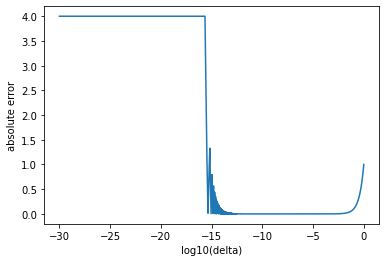

In [2]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return x**2

def dfdx(x):
    return 2*x

def finite_diff(f, x, delta):
    return (f(x+delta)-f(x))/delta

def error(analytical, numerical):
    return np.abs(analytical-numerical)
    
n = 10000
x = np.linspace(-2,2,n)



deltas = np.logspace(-30, 0, n+1)
eps = np.zeros(n+1)
a = 2

analytical = dfdx(a)

for i, delta in enumerate(deltas, start = 0):
    numerical = finite_diff(f, a, delta)
    eps[i] = error(analytical, numerical)

fig, ax = plt.subplots()
ax.plot(np.log10(deltas), eps)
plt.xlabel("log10(delta)")
plt.ylabel("absolute error")

print("The smallest error eps = %g was with delta = %g" %(np.min(eps), deltas[np.argmin(eps)]))

We can se that for $\Delta < 10^{-13}$ (circa), the formulary becomes very unstable. And we never really get a precice value for $\frac{df}{dx}\Biggr|_{x=2}$; we're off by $\sim 10^{-10}$. That is to say: an error on the magnitude of $10^{-10}$ is a decent enough result if we're to evaluete the derivative of one function at one point, but this is useless if we're to do back propagation. We risk compounding this error, and we can quickly run into overflow. Let's take a look at another method of differentiation: automatic differentiation.

We start by example. Let's define a more complex function than $x^2$. Let's try with
$$
f(x)=e^{-x^2+3x-2}+e^{\arctan{x}*e^{-x/2}}
$$
We find the derivative of $f(x)$ to be
$$
\frac{df}{dx} = e^{-x^2+3x-2}(3-2x)+e^{e^{-x/2}\arctan{x}}\Biggr(
\frac{e^{-x/2}}{x^2+1}-\frac{1}{2}e^{-x/2}\arctan{x}
\Biggr)
$$
Thank the gods Wolfram Alpha is a thing, right?

In [3]:
def f(x):
    return np.exp(-(x**2-3*x+2))+np.exp(np.arctan(x)*np.exp(-x/2))
def dfdx_analytical(x):
    term1 = np.exp(-x**2+3*x-2)*(3-2*x)
    term2 = np.exp(np.exp(-x/2)*np.arctan(x))
    term3 = np.exp(-x/2)/(x**2+1)-1/2*np.exp(-x/2)*np.arctan(x)
    term4 = term2*term3
    return term1 + term4

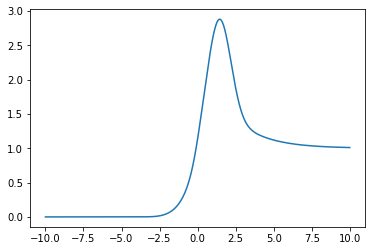

In [4]:
x = np.linspace(-10,10,n)
plt.plot(x, f(x))


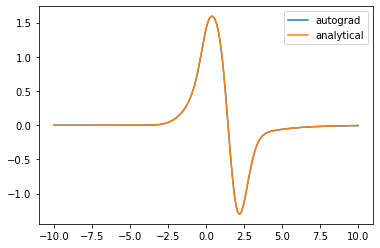

In [5]:
import autograd.numpy as np
from autograd import elementwise_grad as egrad
dfdx_auto = egrad(f)

plt.plot(x, dfdx_auto(x), label = "autograd")
plt.plot(x,dfdx_analytical(x), label = "analytical")
plt.legend()

It seems the autograd is quite close, but it's hard to tell. Let's check the maximum error.

In [6]:
absoluteError = np.abs(dfdx_auto(x)-dfdx_analytical(x))
print(np.max(absoluteError))

7.216449660063518e-16


A significant improvement to the previous result with the finite difference method. But how does this magic work? I will try to explain. The key words are "computational graphs". Let' just jump right in. Let's start by defining a funtion $f$, such that


$$
f(x_1,x_2) = x_1x_2\sin{x_2}
$$


We can represent this function with the following computational graph (that i stole from https://marksaroufim.medium.com/automatic-differentiation-step-by-step-24240f97a6e6).


![uh!](https://miro.medium.com/v2/resize:fit:720/format:webp/1*N_VV1FmBRzDOOJHBA3FQEQ.png)

with 
$$
v_1=x_1=2
$$
$$
v_2=x_2=3
$$

Now doen't this look a little like a neural network?

![uuuhh](https://victorzhou.com/media/nn-series/network.svg)

Foreshadowing, right? But you might want to know how this actually relates to derivatives. I'll show you:
$$
\dot{v_i}=\frac{\partial v_i}{\partial x_j}
$$


Let's evaluate all these derivatives

$$
\dot{v_1}=\frac{\partial x_1}{\partial x_2}=0
$$
$$
\dot{v_2}=\frac{\partial x_2}{\partial x_2}=1
$$
$$
\dot{v_3}=\dot{v_1}v_2+v_1\dot{v_2}=2
$$
$$
\dot{v_4}=\frac{\partial}{\partial v_2}\sin{v_2}=\cos{v_2}=\cos{3}
$$
$$
\dot{v_5}=\dot{v_3}-\dot{v_4}=2-\cos{3}\approx 1
$$

Now you might think that this is a bit a heavy, to only get the partial derivatives w.r.t. $x_2$. Let's now consider general vector valued functions:
$$
f:\mathbb{R}^n\mapsto\mathbb{R}^m
$$
and its derivatives in the form of the Jacobian matrix $J_f$
$$
J_f=
\begin{pmatrix}
\frac{\partial y_1}{\partial x_1} & \cdots & \frac{\partial y_1}{\partial x_n}\\
\vdots & \ddots & \vdots\\
\frac{\partial y_m}{\partial x_1} & \cdots & \frac{\partial y_m}{\partial x_n}\\
\end{pmatrix}
$$

We can see that using the method we used for finding the derivatives (forward mode) must be really slow when working with large $n, m$